# PT1 (Data Cleaning) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
plt.style.use('ggplot')
pd.options.display.max_columns=100

In [3]:
df=pd.read_csv(r"C:\Users\berid\python\csv_files\amazon_co-ecommerce_sample.csv")

In [4]:
df.sample()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
1146,3781e4019036810064de27fa44ac182c,A Nightmare on Elm Street - Freddy Krueger Bob...,Wacky Wobbler,£12.99,14 new,9,2.0,4.3 out of 5 stars,Hobbies > Collectible Figures & Memorabilia > ...,http://www.amazon.co.uk/Jason-Voorhees-Friday-...,"Product Description Fred ""Freddy"" Krueger is t...",Technical Details Item Weight204 g Product Dim...,"Product Description Fred ""Freddy"" Krueger is t...",http://www.amazon.co.uk/Jason-Voorhees-Friday-...,NaN,Just the job // 5.0 // 11 April 2014 // By\n ...,"{""seller""=>[{""Seller_name_1""=>""all your music""..."


In [5]:
reviews=[str(review).split('//')[0] for review in df['customer_reviews']]

dates=[]
for review in df['customer_reviews']:
    try:
        date=str(review).split('//')[2].strip()
        dates.append(date)
    except IndexError:
        dates.append(str(review))
        
stars=[]
for review in df['customer_reviews']:
    try:
        star=str(review).split('//')[1].strip()
        stars.append(star)
    except IndexError:
        stars.append(str(review))

In [6]:
df['Reviews']=reviews
df['Review_Date']=dates
df['Stars']=pd.to_numeric(pd.Series(stars),errors='coerce')
df['price']=pd.to_numeric(df['price'].str.split('£').str[-1],errors='coerce')

In [7]:
df['Review_Date']=df['Review_Date'].replace('nan',None).replace('5.0',None)

In [8]:
df['Review_Date']=pd.to_datetime(df['Review_Date'])

In [9]:
df.sample()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,Reviews,Review_Date,Stars
5785,de382debee7c5461940f87579e9909f8,"Disney Planes ""2"" Muir - Deluxe Die Cast (Meta...",Planes,35.98,NaN,2,2.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Planes-2-Fire-Rescue-D...,Get their imagination on track as they recreat...,Technical Details Item Weight522 g Product Dim...,Get their imagination on track as they recreat...,http://www.amazon.co.uk/Disney-Planes-Muir-Tra...,NaN,big hit but very heavy // 4.0 // 27 Feb. 2015 ...,"{""seller""=>{""Seller_name_1""=>""wmdservices"", ""S...",big hit but very heavy,2015-02-27,4.0


In [10]:
bad_index=df.query('Reviews.str.len()<10 and Reviews.str.contains("Star",case=False,regex=True)').index

df=df.drop(bad_index)

# PT2 (Sentiment Analysis)

In [11]:
# VADER dependencies

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia=SentimentIntensityAnalyzer()

In [12]:
# ROBERTA dependencies

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [13]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    try:
        text=row['Reviews']
        myid=row['uniq_id']
        vader_res=sia.polarity_scores(text)
        roberta_res=polarity_scores_roberta(text)
        both={**vader_res,**roberta_res}
        res[myid]=both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/9989 [00:00<?, ?it/s]

In [17]:
results_df=pd.DataFrame(res).T.reset_index()
results_df=results_df.rename(columns={'neg':'vader_neg','neu':'vader_neu','pos':'vader_pos','compound':'vader_compound'})

df=df.merge(results_df,left_on='uniq_id',right_on='index')
df.sample()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,Reviews,Review_Date,Stars,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
961,357beb7903d1c69a28ecd0ff85f5dc91,Siku 4487 John Deere 8360RT Silver Edition (Li...,Siku,39.48,NaN,1,1.0,5.0 out of 5 stars,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,http://www.amazon.co.uk/Britains-43006-Kane-Lo...,Siku 4487 John Deere 8360 RT train tracks - li...,Technical Details Item Weight9 g Product Dimen...,Siku 4487 John Deere 8360 RT train tracks - li...,http://www.amazon.co.uk/Britains-42266-Scale-D...,NaN,Five Stars // 5.0 // 23 Nov. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Rudolphs Schatzk...",Five Stars,2015-11-23,5.0,357beb7903d1c69a28ecd0ff85f5dc91,0.0,1.0,0.0,0.0,0.062237,0.709577,0.228187


# Visualize Results

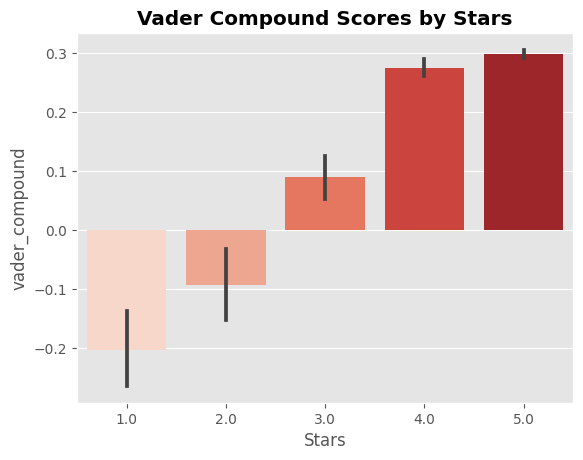

In [19]:
sns.barplot(df,x='Stars',y='vader_compound',palette='Reds')
plt.title('Vader Compound Scores by Stars',fontweight='bold')
plt.show()

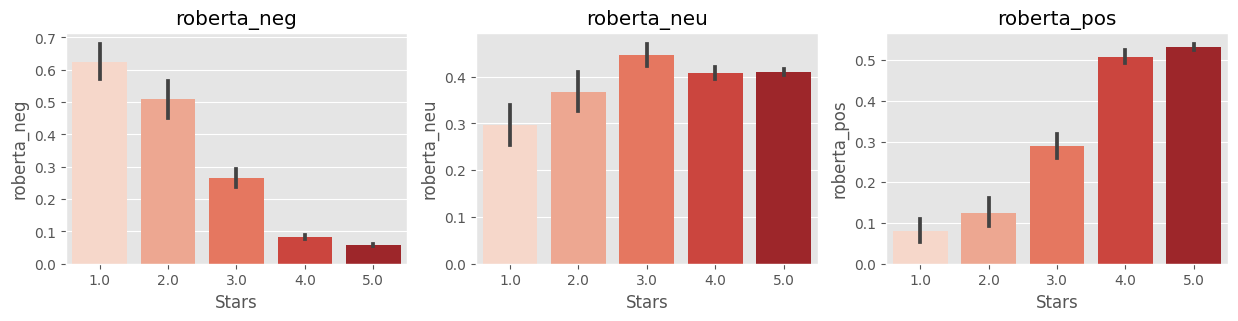

In [35]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,3))
sns.barplot(df,x='Stars',y='roberta_neg',ax=ax1,palette='Reds')
sns.barplot(df,x='Stars',y='roberta_neu',ax=ax2,palette='Reds')
sns.barplot(df,x='Stars',y='roberta_pos',ax=ax3,palette='Reds')

ax1.set_title('roberta_neg'),ax2.set_title('roberta_neu'),ax3.set_title('roberta_pos')

plt.show()

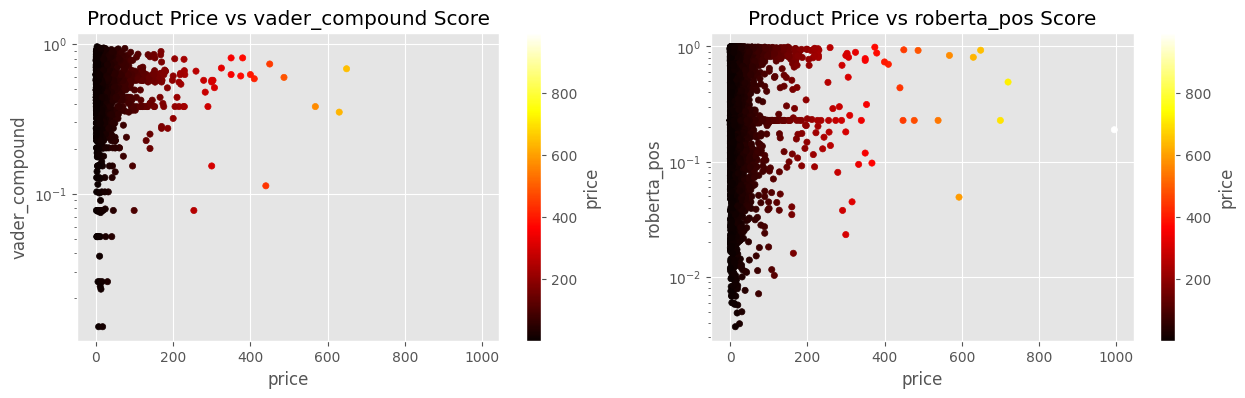

In [46]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4))

df.plot.scatter(ax=ax1,x='price',y='vader_compound',c='price',cmap='hot',title='Product Price vs vader_compound Score')
ax1.set_yscale('log')
df.plot.scatter(ax=ax2,x='price',y='roberta_pos',c='price',cmap='hot',title='Product Price vs roberta_pos Score')
ax2.set_yscale('log')
plt.show()

# There is a correlation between product price and the opinion of a customer. 
# Products with positive reviews tend to have higher price, then the products with negative reviews, which is logical

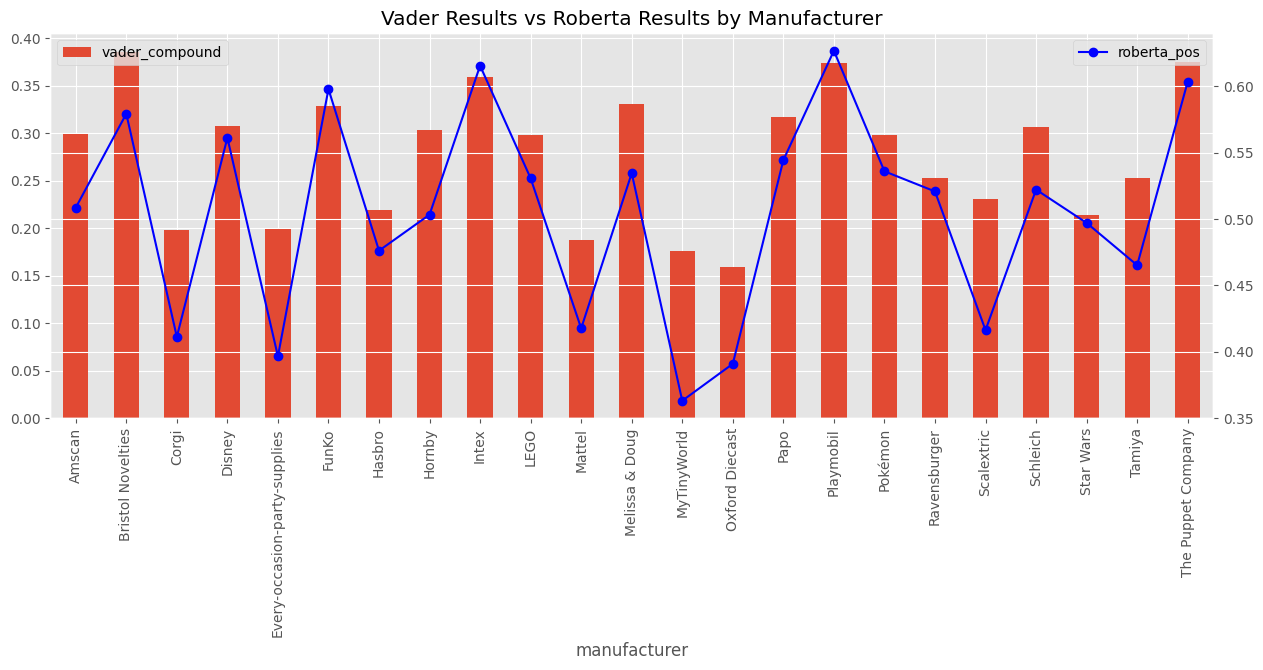

In [70]:
grouped=df.groupby('manufacturer').agg({'vader_compound':'mean','roberta_pos':'mean','uniq_id':'count','price':'mean'})\
.query('uniq_id>50')\
#.sort_values('vader_compound',ascending=False)

fig,ax=plt.subplots(figsize=(15,5))
grouped.plot.bar(ax=ax,y='vader_compound',label='vader_compound')
ax2=ax.twinx()
grouped.plot.line(ax=ax2,y='roberta_pos',color='b',label='roberta_pos',marker='o')
ax.legend(loc='upper left')
ax2.legend()
plt.title('Vader Results vs Roberta Results by Manufacturer')
plt.show()

In [72]:
# Both models output close results in most of the cases